<a href="https://colab.research.google.com/github/jimohafeezco/computer_cision/blob/master/colorspaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! wget "http://drive.google.com/uc?export=view&id=1EF4ke1LBRyYM0tfbgiV7c0LPogAs7wz0" -O dog.jpg
! wget "http://drive.google.com/uc?export=view&id=106iRabptomx9nfWbwjo1xYQHhX31QuGg" -O beatles.jpg

--2020-09-15 20:17:58--  http://drive.google.com/uc?export=view&id=1EF4ke1LBRyYM0tfbgiV7c0LPogAs7wz0
Resolving drive.google.com (drive.google.com)... 172.217.203.138, 172.217.203.113, 172.217.203.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.138|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/uc?export=view&id=1EF4ke1LBRyYM0tfbgiV7c0LPogAs7wz0 [following]
--2020-09-15 20:17:58--  https://drive.google.com/uc?export=view&id=1EF4ke1LBRyYM0tfbgiV7c0LPogAs7wz0
Connecting to drive.google.com (drive.google.com)|172.217.203.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ms6duc09osc8tomv0pejpabbclk7njl8/1600201050000/00197501137516660733/*/1EF4ke1LBRyYM0tfbgiV7c0LPogAs7wz0?e=view [following]
--2020-09-15 20:17:59--  https://doc-00-04-docs.googleusercontent.com/docs/s

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
plt.rcParams["figure.figsize"] = (32, 60) # (w, h)

import numpy as np
import time, cv2, math
from typing import AnyStr, Any, Callable


# Helper functions
def read_image(filename: str, grayscale: bool = False, fx: float = 1.0, fy: float = 1.0):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      # convert to rgb
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    if fx != 1.0 and fy != 1.0:
      img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result

    
def show_in_row(list_of_images: list, titles: list = None, disable_ticks: bool = False):
  if type(list_of_images) != list:
    list_of_images = [list_of_images]
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

def show_in_col(list_of_images: list, titles: list = None, disable_ticks: bool = False):
  if type(list_of_images) != list:
    list_of_images = [list_of_images]
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(count, 1, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

## Lab Objectives
Image segmentation with classic approach (SLIC)<br>

![alt text](https://ivrl.epfl.ch/wp-content/uploads/2018/08/54082_combo.jpg)

## The Algorithm

1) Convert image to LAB colorspace<br>
2) Initalize **K** clusters `[L, A, B, x, y]` in low gradient area<br>
3) For each pixel find closest cluster <br>
4) Move cluster to mean pixel <br>
5) Repeat steps 3 & 4 10 times <br>

----

More information [here](https://jayrambhia.com/blog/superpixels-slic) and [here (Video)](https://www.youtube.com/watch?v=-hmUbB-Y8R0)

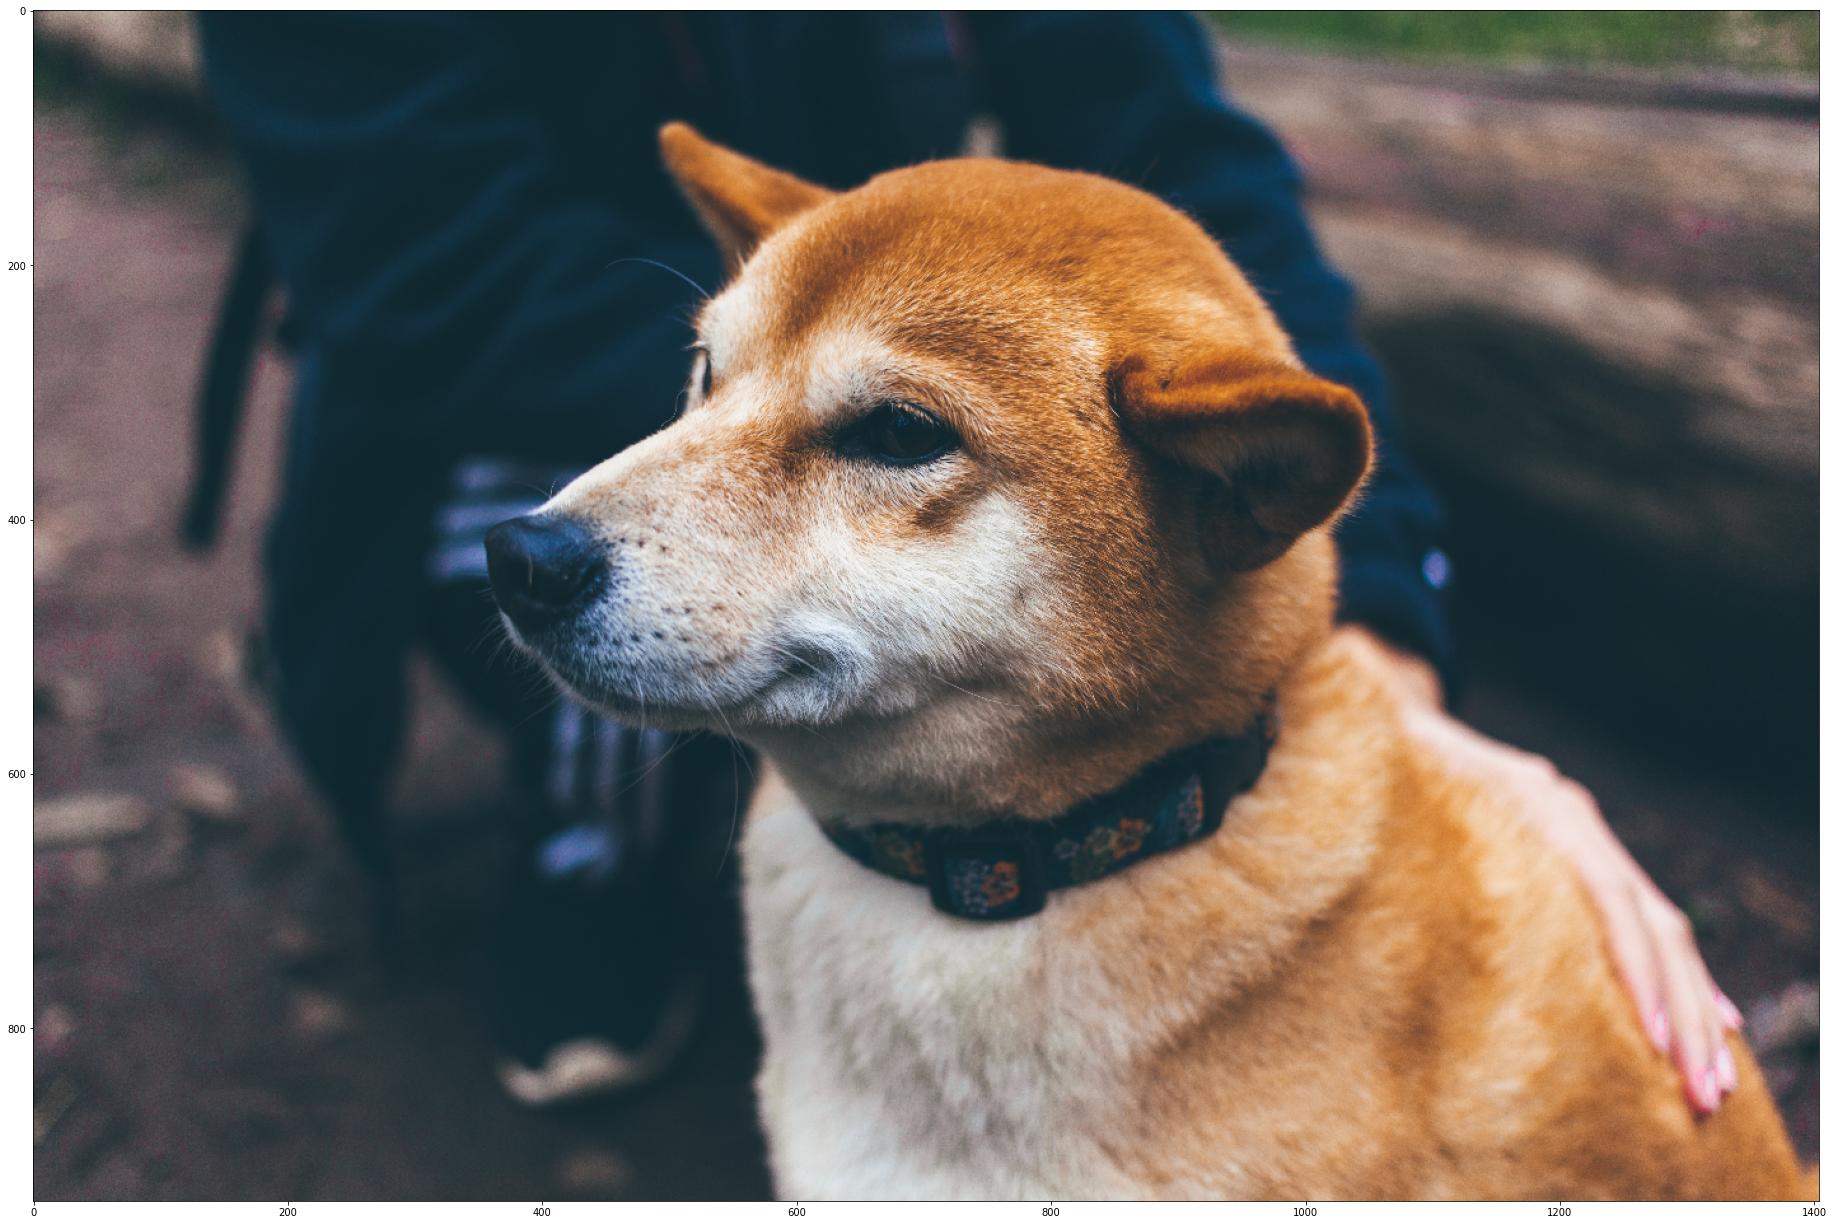

In [ ]:
# check image
orig_img = read_image("dog.jpg", False, 0.25, 0.25)
show_in_row([orig_img])

### 1) LAB colorspace

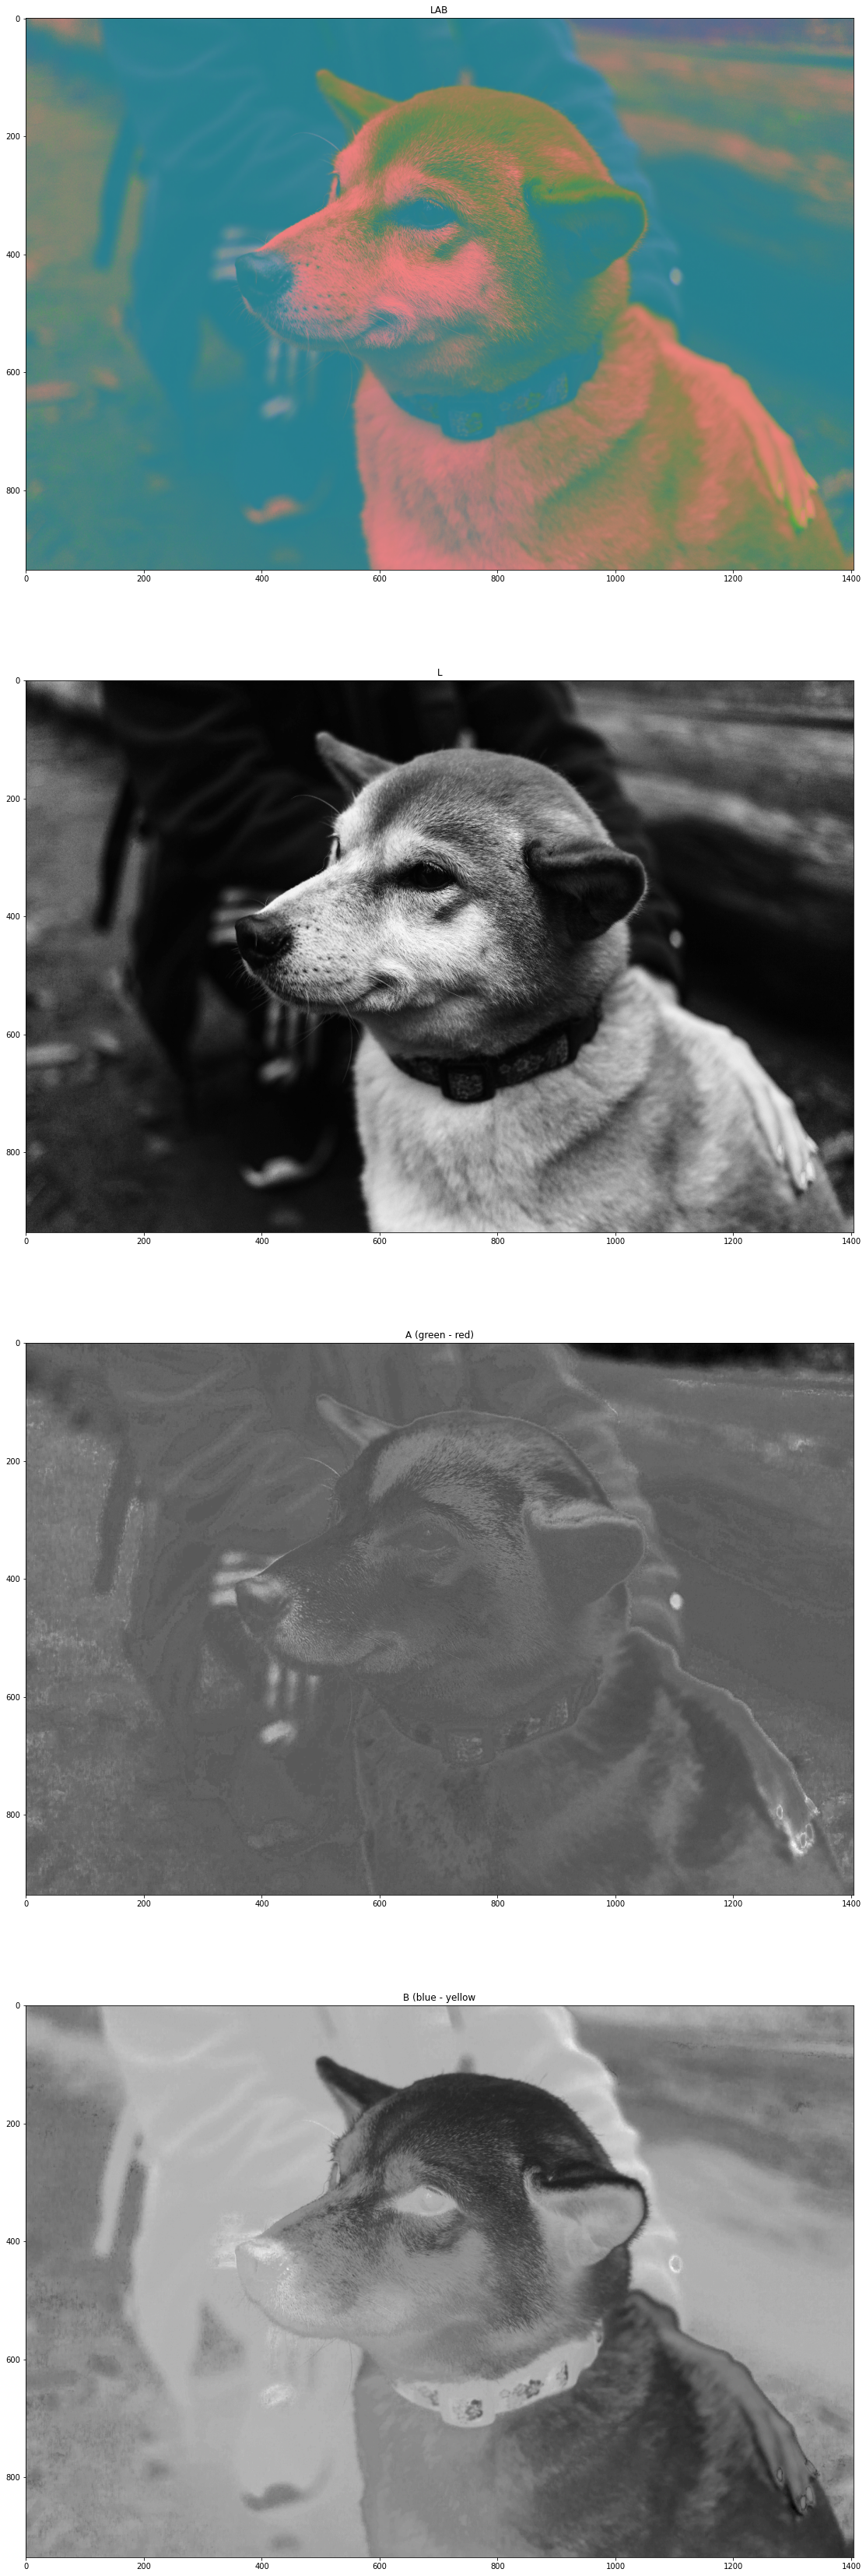

In [ ]:
def to_lab(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# test lab
lab_img = to_lab(orig_img)

L, A, B = cv2.split(lab_img)
show_in_col([lab_img, L, A, B], ["LAB", "L", "A (green - red)", "B (blue - yellow"])

### 2) Initialization

In [ ]:
def find_local_minimum(gray_img: np.array, pos: tuple, check_grid_area: tuple) -> tuple:
    # Given a greyscale image, a point in this image and a grid of size check_grid_area
    # around this point, this function returns the position of the minimum in this grid.
    # print(check_grid_area)
    offset_x = check_grid_area//2
    offset_y = check_grid_area//2
    x = pos[0]
    y = pos[1]
    roi = gray_img[x-offset_x:x+offset_x,y-offset_y:y+offset_y]
    
    minima_index = np.unravel_index(np.argmin(roi),roi.shape)
    return minima_index
    


    
            

def slic_init(img: np.array, clusters_count: int, check_grid_area: tuple = None) -> list:
    # Initalize clusters in low gradient
    # returns list of clusters [{"pos": (x, y), "color": (color_tuple)}]

    #distance between cluster centers
    step = (img.shape[0] * img.shape[1] / float(clusters_count)) ** 0.5
    step = int(step)

    if check_grid_area is None:
        check_grid_area = (int(step * 0.2), int(step * 0.2))

    clusters = []

    # print(img.shape)

    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)

    #magnitude - values of gradient and we should take n clusters from it
    mag, ang = cv2.cartToPolar(sobelx,sobely)

    hor_clusters = img.shape[1]//step
    ver_clusters = img.shape[0]//step


    cluster_centers=[]
    cluster0 = (step//2,step//2)
    cluster_centers.append(cluster0)

    x_vals=0
    y_vals=0
    for i in range(0,ver_clusters):
        x_vals=0
        
        for j in range(1,hor_clusters):


            prev_cluster = cluster_centers[i+j-1]

            
            

            new_cluster_ver = i*step
            new_cluster_hor = x_vals

            x_vals+=step
            # print(new_cluster_ver,new_cluster_hor)

            cluster_centers.append((new_cluster_ver,new_cluster_hor))
            



    refined_cluster_centers=[]
    for i in cluster_centers:
        new_cluster = find_local_minimum(mag,i,step)
        # print(new_cluster)
        refined_cluster_centers.append(new_cluster)

    # print(len(cluster_centers))
    return cluster_centers

def draw_cluster_centers(img, color, clusters):
    # print(len(clusters))
    for c in clusters:
        # print(c)
        # pos = c["pos"]
        pos = c
        pos = (int(pos[1]), int(pos[0]))
        cv2.circle(img, pos, 3, color, -1)

n_count = 150
clusters = slic_init(lab_img, n_count)
print("Expected:",n_count, "Result:", len(clusters))

# debug draw
debug_img = orig_img.copy()
draw_cluster_centers(debug_img, (0, 255, 0), clusters)
show_in_row(debug_img)

ValueError: ignored

In [ ]:
print(orig_img.shape)

### 3-4) Connect pixels to clusters, move clusters

In [ ]:
def do_step(lab_img: np.array, clusters: list, m: float = 45) -> list:
    # return list of new clusters
    
    big_value = 1000000.0
    distances = big_value * np.ones(lab_img.shape[:2])
    clusters_indexes = np.ones(lab_img.shape[:2]) * (-1)
    
    new_clusters = []
    step = (lab_img.shape[0] * lab_img.shape[1] / float(len(clusters))) ** 0.5
    dist_multiplier = m / step
    max_distance = 2 * step
    
    for idx, c in enumerate(clusters):
        p = c["pos"]
        from_y = int(max(0, p[0] - max_distance))
        to_y = int(min(lab_img.shape[0], p[0] + max_distance + 1))
        from_x = int(max(0, p[1] - max_distance))
        to_x = int(min(lab_img.shape[1], p[1] + max_distance + 1))
        
        # Calculate the pixel distance (np.ogrid or np.mgrid might be helpful)
        pix_dist = < your code here >
        
        # Calculate color distance
        color_dist = < your code here >
        
        # Combine these distances to one distance measure
        sum_dist = < your code here >
        
        # Assign pixels to this cluster when calculated distance smaller than
        # the previously calculated distance
        indexes = distances[from_y:to_y, from_x:to_x] > sum_dist
        distances[from_y:to_y, from_x:to_x][indexes] = sum_dist[indexes]
        clusters_indexes[from_y:to_y, from_x:to_x][indexes] = idx
    
    # Calculate new cluster centers
    indnp = np.mgrid[0:lab_img.shape[0], 0:lab_img.shape[1]].transpose(1, 2, 0)
    for k in range(len(clusters)):
        idx = (clusters_indexes == k)
        new_color = < your code here >
        new_pos = < your code here >
        new_clusters.append({'pos': new_pos, 'color': new_color})
    return new_clusters, clusters_indexes

def color_clusters(img, clusters, clusters_indexes):
  draw_image = img.copy()
  for k in range(len(clusters)):
      idx = (clusters_indexes == k)
      draw_image[idx] = clusters[k]['color']
  return cv2.cvtColor(draw_image, cv2.COLOR_LAB2BGR)

test_clusters = clusters.copy()
debug_img = orig_img.copy()
draw_cluster_centers(debug_img, (0, 255, 0), test_clusters)
for i in range(10):
    color = (i*5, 0, 255)
    test_clusters, cluster_indices = do_step(lab_img, test_clusters)
    draw_cluster_centers(debug_img, color, test_clusters)
    print("step", i)
show_in_row([debug_img, color_clusters(orig_img, test_clusters, cluster_indices), cluster_indices])
print("done")